In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import colormaps, misc

from reni.configs.reni_config import RENIField
from reni.configs.sh_sg_envmap_configs import SHField, SGField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

In [2]:
# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    if 'latent_dim' in config['pipeline']['model']['field'].keys():
        
        model_config = RENIField.config
        model_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
        model_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
        if config['pipeline']['datamanager']['dataparser']['eval_mask_path'] is not None:
            eval_mask_path = Path(os.path.join(*config['pipeline']['datamanager']['dataparser']['eval_mask_path']))
            model_config.pipeline.datamanager.dataparser.eval_mask_path = eval_mask_path
        else:
            model_config.pipeline.datamanager.dataparser.eval_mask_path = None
        if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
        else:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
        model_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
        model_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
        model_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
        model_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
        model_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
        model_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
        model_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
        model_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
        model_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
        model_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
        model_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
        model_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
        model_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
        model_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
        model_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
        model_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
        model_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
        model_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    elif 'spherical_harmonic_order' in config['pipeline']['model']['field'].keys():
        model_config = SHField.config
        model_config.pipeline.model.field.spherical_harmonic_order = config['pipeline']['model']['field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['field'].keys():
        model_config = SGField.config
        model_config.pipeline.model.field.row_col_gaussian_dims = config['pipeline']['model']['field']['row_col_gaussian_dims']

    pipeline: RENIPipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model

def generate_images_from_models(image_indices, model_paths):
    all_model_outputs = {}
    
    for model_path in model_paths:
        model_name = model_path.split("/")[-1]
        pipeline, datamanager, model = load_model(Path(model_path))
        
        model_outputs = {}
        
        for idx in image_indices:
            # Your code to produce an image would go here.
            model.eval()
            _, ray_bundle, batch = datamanager.next_eval_image(idx)
            H, W = model.metadata["image_height"], model.metadata["image_width"]

            # High res image:
            H = 64
            W = H * 2
            cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
            cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
            fx = torch.tensor(H, dtype=torch.float32).repeat(1)
            fy = torch.tensor(H, dtype=torch.float32).repeat(1)

            c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

            cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

            ray_bundle = cameras.generate_rays(0).flatten().to(device)
            ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx

            batch['image'] = batch['image'].to(device)

            # check if the model has attribute old_implementation
            if hasattr(model.field, 'old_implementation'):
                if model.field.old_implementation:
                    get_rotation = rot_y
                else:
                    get_rotation = rot_z

            rotation = get_rotation(torch.tensor(np.deg2rad(0.0)).float())
            rotation = rotation.to(device)

            outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle)

            pred_img = model.field.unnormalise(outputs['rgb'])
            gt_image = model.field.unnormalise(batch['image'])

            # rehsape to H, W, C
            gt_image = gt_image.reshape(H, W, 3)
            pred_img = pred_img.reshape(H, W, 3)

            # converting to grayscale by taking the mean across the color dimension
            gt_image_gray = torch.mean(gt_image, dim=-1)
            pred_image_gray = torch.mean(pred_img, dim=-1)

            # reshape to H, W
            gt_image_gray = gt_image_gray.reshape(H, W, 1)
            pred_image_gray = pred_image_gray.reshape(H, W, 1)

            gt_min, gt_max = torch.min(gt_image_gray), torch.max(gt_image_gray)

            combined_log_heatmap = torch.cat([gt_image_gray, pred_image_gray], dim=1)

            combined_log_heatmap = colormaps.apply_depth_colormap(
                combined_log_heatmap,
                near_plane=gt_min,
                far_plane=gt_max,
            )

            gt_heatmap = combined_log_heatmap[:, :W, :]
            pred_heatmap = combined_log_heatmap[:, W:, :]

            pred_img = linear_to_sRGB(pred_img, use_quantile=True)
            gt_img = linear_to_sRGB(gt_image, use_quantile=True)

            if 'mask' in batch:
                mask = batch["mask"].reshape(H, W, 1).expand_as(
                    gt_img
                ).to(device) # [H, W, 3]
                # we should mask gt_image_ldr to show only the pixels that were used in the loss
                gt_img = gt_img * mask

            model_outputs[idx] = {'pred_img': pred_img.cpu().detach(),
                                  'gt_img': gt_img.cpu().detach(),
                                  'pred_heatmap': pred_heatmap.cpu().detach(),
                                  'gt_heatmap': gt_heatmap.cpu().detach(),
                                  'min_max': (gt_min, gt_max)}
        
        if 'masked' in model_path:
            model_name = model_name + '_masked'
            
        all_model_outputs[model_name] = model_outputs
    
    return all_model_outputs

In [3]:
%%capture
image_indices = [1, 2, 3, 4]
model_paths = [
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_9',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_49',
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100',
    '/workspace/outputs/reni/spherical_harmonics/2nd_order',
    '/workspace/outputs/reni/spherical_harmonics/6th_order',
    '/workspace/outputs/reni/spherical_harmonics/9th_order',
    '/workspace/outputs/reni/spherical_gaussians/num_param_30',
    '/workspace/outputs/reni/spherical_gaussians/num_param_150',
    '/workspace/outputs/reni/spherical_gaussians/num_param_300'
]

output_images = generate_images_from_models(image_indices, model_paths)


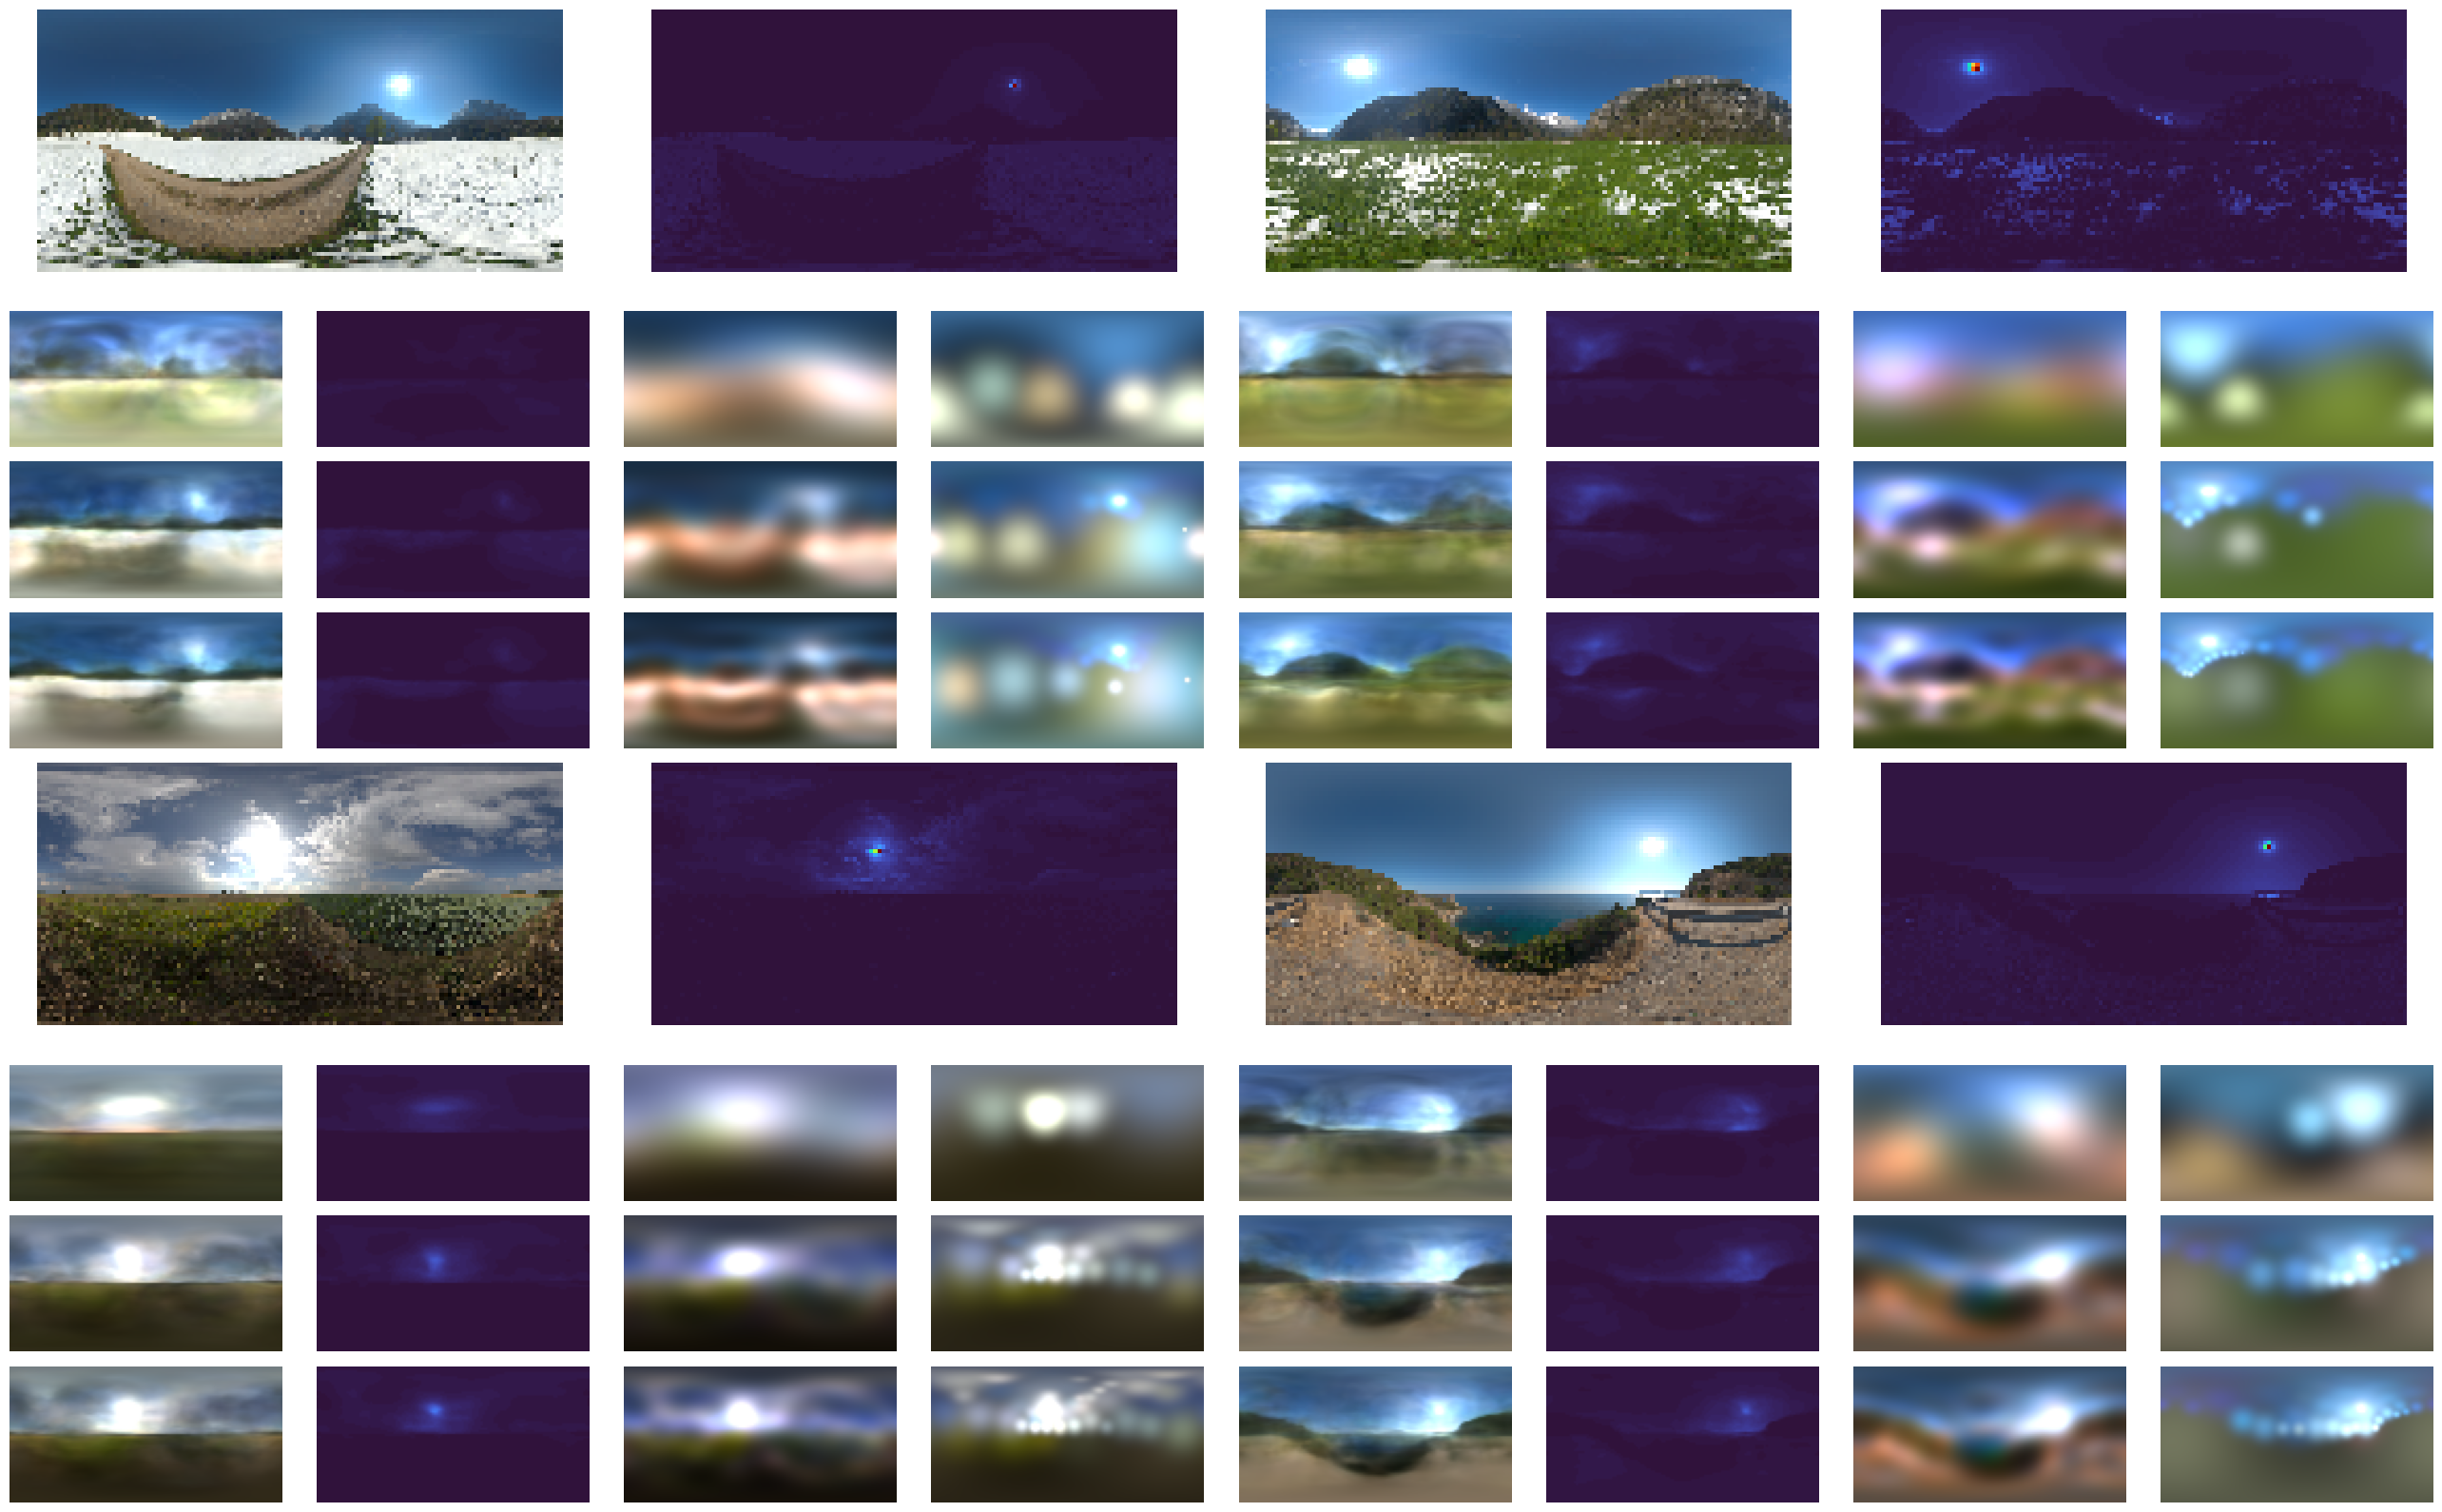

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_images_quadrants(output_images, image_indices, filename=None):
    fig = plt.figure(figsize=(26,16)) # Adjusted for equirectangular

    reni_tags = ['latent_dim_9', 'latent_dim_49', 'latent_dim_100']
    sh_tags = ['2nd_order', '6th_order', '9th_order']
    sg_tags = ['num_param_30', 'num_param_150', 'num_param_300']
    
    rows_per_idx = len(reni_tags) + 2
    cols_per_model = 4  # 2 for reni, 1 for sh and 1 for sg
    
    for i, idx in enumerate(image_indices):
        row_offset = (i // 2) * rows_per_idx
        col_offset = (i % 2) * cols_per_model

        # GT image and heatmap
        gt_img = output_images[reni_tags[0]][idx]['gt_img']
        gt_heatmap = output_images[reni_tags[0]][idx]['gt_heatmap']

        # Calculate the padding
        h, w, _ = gt_img.shape
        padding_percent = 10
        padding = int(h * padding_percent / 100.0)
        
        # Pad the images
        padded_gt_img = np.pad(gt_img, [(0, padding), (0, 0), (0, 0)], mode='constant', constant_values=1)
        padded_gt_heatmap = np.pad(gt_heatmap, [(0, padding), (0, 0), (0, 0)], mode='constant', constant_values=1)
        
        # GT image and heatmap
        ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset, col_offset), rowspan=2, colspan=2)
        ax.imshow(padded_gt_img)
        ax.axis('off')
        ax.set_aspect(1)

        ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset, col_offset+2), rowspan=2, colspan=2)
        ax.imshow(padded_gt_heatmap)
        ax.axis('off')
        ax.set_aspect(1)

        for j in range(3):  # 3 model sizes
            # RENI images
            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset))
            ax.imshow(output_images[reni_tags[j]][idx]['pred_img'])
            ax.axis('off')
            ax.set_aspect(1)

            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset + 1))
            ax.imshow(output_images[reni_tags[j]][idx]['pred_heatmap'])
            ax.axis('off')
            ax.set_aspect(1)

            # Spherical Harmonics images
            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset + 2))
            ax.imshow(output_images[sh_tags[j]][idx]['pred_img'])
            ax.axis('off')
            ax.set_aspect(1)
            
            # Spherical Gaussians
            ax = plt.subplot2grid((2*rows_per_idx, 2*cols_per_model), (row_offset + 2 + j, col_offset + 3))
            ax.imshow(output_images[sg_tags[j]][idx]['pred_img'])
            ax.axis('off')
            ax.set_aspect(1)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(f"{filename}.png")
        plt.savefig(f"{filename}.pdf")
    
    plt.show()

# Assuming output_images is defined
plot_images_quadrants(output_images, image_indices, filename='reni_neus/ns_reni/publication/figures/comparison')

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

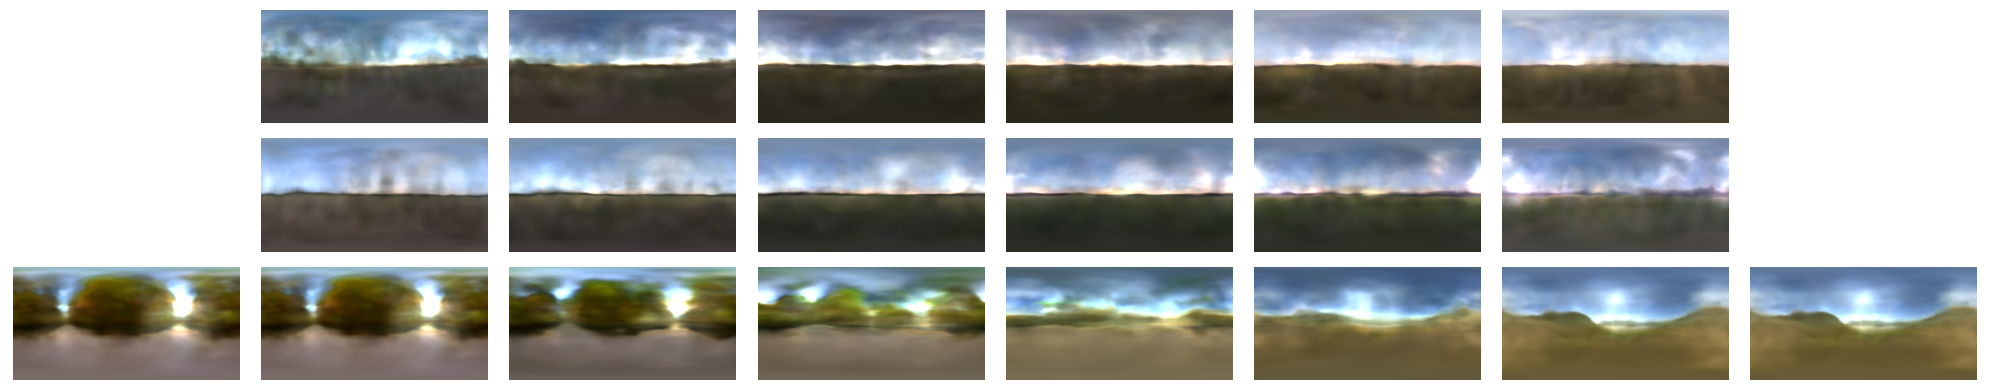

In [9]:
# Interpolation
def lerp(start, end, t):
    return start * (1 - t) + end * t

import matplotlib.pyplot as plt
import numpy as np
import torch

pipeline, datamanager, model = load_model(Path('/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100'))
model.eval()
idx = 0
_, ray_bundle, batch = datamanager.next_eval_image(idx)
H, W = model.metadata["image_height"], model.metadata["image_width"]

# High res image:
H = 256
W = H * 2
cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(H, dtype=torch.float32).repeat(1)
fy = torch.tensor(H, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(0).flatten().to(device)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx

batch['image'] = batch['image'].to(device)

# we need ray_samples for the field
if len(ray_bundle.directions.shape) == 3: # [2, num_rays, 3]
    assert model.config.loss_inclusions['scale_inv_grad_loss']
    assert ray_bundle.directions.shape[0] == 2
    # then we are using the finite diff gradient matching loss
    # and the ray_bundle is of shape [2, num_rays, 3]
    # we the second half of the rays are just the directions rolled by 1
    ray_samples = model.create_ray_samples(ray_bundle.origins[0], ray_bundle.directions[0], ray_bundle.camera_indices[0])
else:
    ray_samples = model.create_ray_samples(ray_bundle.origins, ray_bundle.directions, ray_bundle.camera_indices)

if model.field.old_implementation:
    get_rotation = rot_y
else:
    get_rotation = rot_z

def plot_interpolated_images(model, K=10, idx1=None, idx2=None, filename=None):
    # Create a figure with 3 rows, but now K+2 columns for the last row
    fig, axs = plt.subplots(3, K + 2, figsize=(20, 4))
    
    # Hide the extra two columns in the first two rows
    for row in range(2):
        axs[row, -1].axis('off')
        axs[row, 0].axis('off')
        
        latent_code_1 = torch.randn(1, model.field.latent_dim, 3).to(device)
        latent_code_2 = torch.randn(1, model.field.latent_dim, 3).to(device)
        
        for col in range(1, K + 1):
            t = (col - 1) / (K - 1)
            interpolated_latent_code = lerp(latent_code_1, latent_code_2, t)
            interpolated_latent_code = interpolated_latent_code.repeat(ray_samples.shape[0], 1, 1)
            
            field_outputs = model.field.forward(ray_samples, rotation=None, latent_codes=interpolated_latent_code)
            image = field_outputs[RENIFieldHeadNames.RGB].reshape(H, W, 3)
            image = model.field.unnormalise(image)
            image = linear_to_sRGB(image, use_quantile=True)
            image = image.cpu().detach()
            
            axs[row, col].imshow(image.numpy())
            axs[row, col].axis('off')
    
    if idx1 is None:
        idx1 = np.random.choice(range(len(datamanager.eval_dataset)))
    if idx2 is None:
        idx2 = np.random.choice(range(len(datamanager.eval_dataset)))
    latent_code_1 = model.field.eval_mu[idx1].unsqueeze(0)
    latent_code_2 = model.field.eval_mu[idx2].unsqueeze(0)
    
    # Show uninterpolated latent codes on either end
    for col, latent_code in zip([0, -1], [latent_code_1, latent_code_2]):
        pure_latent_code = latent_code.repeat(ray_samples.shape[0], 1, 1)
        field_outputs = model.field.forward(ray_samples, rotation=None, latent_codes=pure_latent_code)
        image = field_outputs[RENIFieldHeadNames.RGB].reshape(H, W, 3)
        image = model.field.unnormalise(image)
        image = linear_to_sRGB(image, use_quantile=True)
        image = image.cpu().detach()
        
        axs[2, col].imshow(image.numpy())
        axs[2, col].axis('off')
    
    # Show interpolated latent codes
    for col in range(1, K + 1):
        t = (col - 1) / (K - 1)
        interpolated_latent_code = lerp(latent_code_1, latent_code_2, t)
        interpolated_latent_code = interpolated_latent_code.repeat(ray_samples.shape[0], 1, 1)
        
        field_outputs = model.field.forward(ray_samples, rotation=None, latent_codes=interpolated_latent_code)
        image = field_outputs[RENIFieldHeadNames.RGB].reshape(H, W, 3)
        image = model.field.unnormalise(image)
        image = linear_to_sRGB(image, use_quantile=True)
        image = image.cpu().detach()
        
        axs[2, col].imshow(image.numpy())
        axs[2, col].axis('off')
    
    plt.tight_layout()

    if filename:
        plt.savefig(f"{filename}.png")
        plt.savefig(f"{filename}.pdf")
    
    plt.show()


plot_interpolated_images(model, 6, idx1=6, idx2=12, filename='reni_neus/ns_reni/publication/figures/interpolations_and_random_samples')

In [3]:
%%capture
# Masking
image_indices = [1, 2, 3, 4, 5, 6]
model_paths = [
    '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100',
    '/workspace/outputs/reni/reni_plus_plus_models/masked_models/latent_dim_100'
]

output_images = generate_images_from_models(image_indices, model_paths)

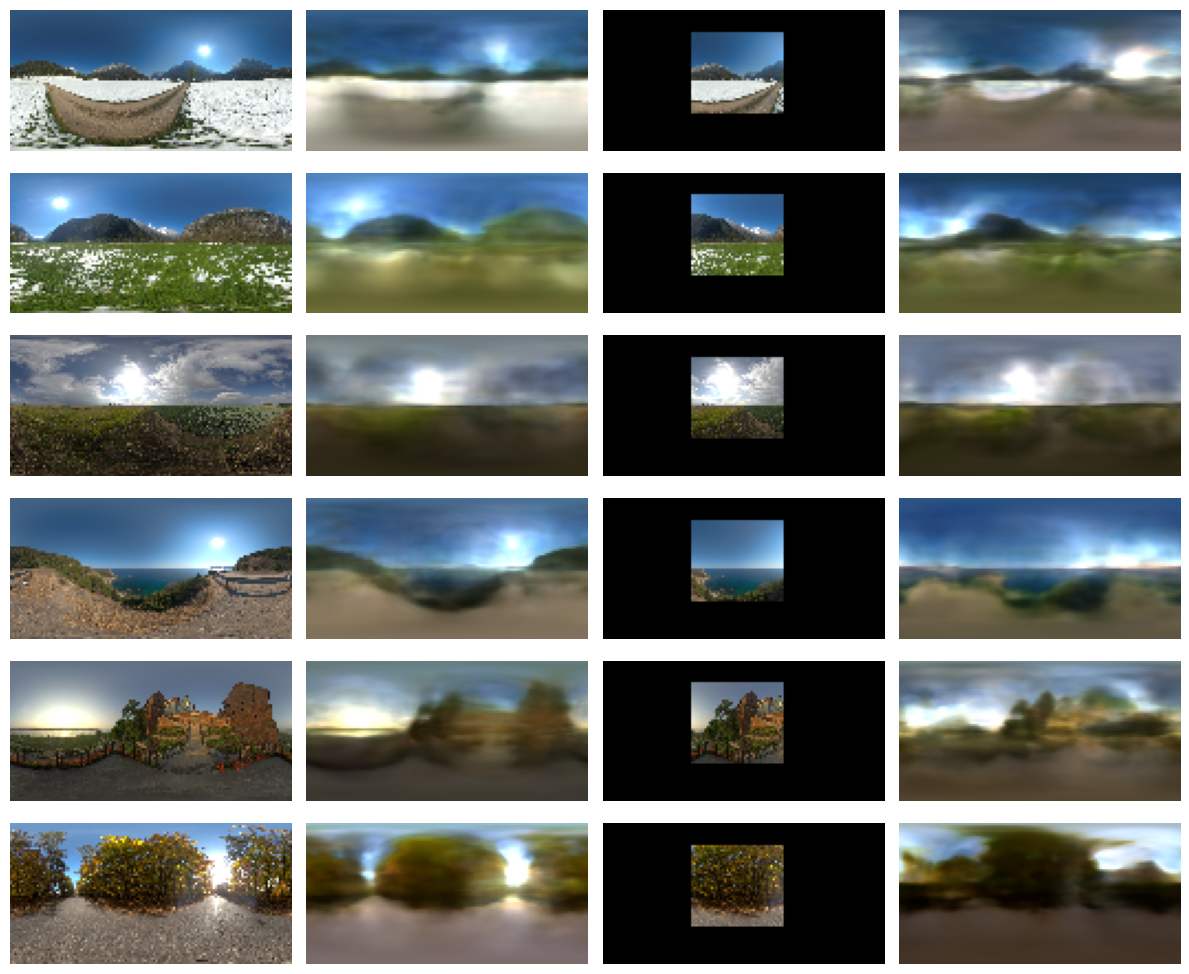

In [17]:
def plot_images(output_images, keys, image_indices, filename=None):
    n_rows = len(image_indices)
    n_cols = 4  # Two pairs of ground truth and predicted images
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    
    for i, idx in enumerate(image_indices):
        # Plot ground truth and predicted images for 'latent_dim_100'
        gt_img1 = output_images[keys[0]][idx]['gt_img']
        pred_img1 = output_images[keys[0]][idx]['pred_img']
        axes[i, 0].imshow(gt_img1)
        axes[i, 0].axis('off')
        axes[i, 0].set_aspect(1)
        
        axes[i, 1].imshow(pred_img1)
        axes[i, 1].axis('off')
        axes[i, 1].set_aspect(1)
        
        # Plot ground truth and predicted images for 'latent_dim_100_masked'
        gt_img2 = output_images[keys[1]][idx]['gt_img']
        pred_img2 = output_images[keys[1]][idx]['pred_img']
        axes[i, 2].imshow(gt_img2)
        axes[i, 2].axis('off')
        axes[i, 2].set_aspect(1)
        
        axes[i, 3].imshow(pred_img2)
        axes[i, 3].axis('off')
        axes[i, 3].set_aspect(1)
    
    plt.tight_layout()

    if filename:
        plt.savefig(f"{filename}.png")
        plt.savefig(f"{filename}.pdf")
    

    plt.show()


keys = ['latent_dim_100', 'latent_dim_100_masked']
image_indices = [1, 2, 3, 4, 5, 6]

plot_images(output_images, keys, image_indices, filename='reni_neus/ns_reni/publication/figures/outpainting')